In [1]:
from model_utils import *

In [6]:
MODEL_NAME = 'skimai/spanberta-base-cased'
FILE = 'data/elmoundo_1202.json'
MAX_SEQ_LENGTH = 128
BATCH_SIZE = 1
CATE_LIMIT = 10
CATE_USE = 3
TASK = 'Soft-presentation'

In [7]:
import datetime
TODAY = datetime.date.today().strftime("%m%d")
RESULT_DIR = 'results/{}-results-{}'.format(TASK,TODAY)
SUB_DIR = 'Soft-Presentation'
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)
if not os.path.exists("{}{}".format(RESULT_DIR,SUB_DIR)):
    os.makedirs("{}{}".format(RESULT_DIR,SUB_DIR))
OUTPUT_PATH = RESULT_DIR + SUB_DIR

In [8]:
# load data
labels,contents,lset,ldic = load_test_data(FILE,CATE_LIMIT,percentage=1)

# encode 1 87s
start = time.time()
encodings_list = pre_encode_list(MODEL_NAME,contents,MAX_SEQ_LENGTH)
print('encoding time cost :',time.time()-start)

# load dataset
train_dataset = NewsCategoryDataset(labels, encodings_list, contents, ldic)
valid_dataset = NewsCategoryDataset(labels, encodings_list, contents, ldic, 'val')
test_dataset = NewsCategoryDataset(labels, encodings_list, contents, ldic, 'test')
print('data loaded \ntrain:{}\nvalid:{}\ntest:{}'.format(len(train_dataset),
                                                          len(valid_dataset),
                                                          len(test_dataset)))

# dataloader
train_val_loaders = {
    "train": DataLoader(dataset=train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True),
    "valid": DataLoader(dataset=valid_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False),
    "test": DataLoader(dataset=test_dataset,
                       batch_size=BATCH_SIZE,
                       shuffle=False)
}

Data loaded:  70 70


100%|████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 1205.81it/s]

Tokenizer loaded...
encoding time cost : 5.025567293167114
data loaded 
train:49
valid:11
test:10


In [5]:
MODELS = [MODEL_NAME]
TYPES = ['raw']
SOURCE = [None]
CATES = [26]

In [6]:
bert_results = []
cls_results = []
tars = []
cates = [i for i in range(CATE_USE)]
for m,ty,src,ca in zip(MODELS,TYPES,SOURCE,CATES):
    if ty == 'raw':
        model = RobertaForSequenceClassification(m,ca)
        if torch.cuda.is_available():
            model = nn.DataParallel(model)
            model.cuda()
    if ty == 'trained':
        model = RobertaForSequenceClassification(m,ca)
        st_dict = torch.load(src)
        model.load_state_dict(st_dict)
    if ty == 'further':
        model = R
    b_result = []
    c_result = []
    lab = []
    model.eval()
    with torch.no_grad():
        for idx,data in enumerate(notetqdm(train_val_loaders['train'])):
            features = data['input_ids'].cuda()
            # print(features.shape)
            att_mask = data['attention_mask'].cuda()
            target = data['targets']
            if target in cates:
                # print(att_mask.shape)
                bert_out = model.module.bert(features,att_mask)
                # print(type(target))
                blist = bert_out[0].tolist()
                clist = bert_out[0][:, 0].tolist()
                tar = target.tolist()[0]
                # print(type(tar))
                b_result.append(blist)
                c_result.append(clist)
                lab.append(tar)
           
    bert_results.append(b_result)
    cls_results.append(c_result)
    tars.append(lab)

SyntaxError: invalid syntax (<ipython-input-6-32421c21b278>, line 13)

In [87]:
len(bert_results[0]), len(cls_results[0]), len(tars[0])

(24, 24, 24)

In [88]:
from matplotlib.colors import rgb2hex
import matplotlib.pyplot as plt

## 2D

In [89]:
tars[0]

[1, 2, 0, 2, 0, 1, 0, 0, 1, 1, 0, 1, 2, 2, 2, 2, 2, 1, 1, 1, 0, 0, 0, 1]

In [90]:
import numpy as np
from sklearn.manifold import MDS
mds2 = MDS(n_components=2)
x = np.squeeze(cls_results[0])
x.shape
x_transformed = mds2.fit_transform(x)
x_transformed.shape

(24, 2)

In [91]:
colors = ['b','g','r']
#colors = tuple([(np.random.random(),np.random.random(),np.random.random()) for i in range(CATE_USE)])
colors = [rgb2hex(x) for x in colors]
dot_color = [colors[i] for i in tars[0]]
xs, ys, cs, ts = x_transformed[:,0], x_transformed[:,1], dot_color, tars[0]
len(xs),len(ys),len(cs),len(ts)

(24, 24, 24, 24)

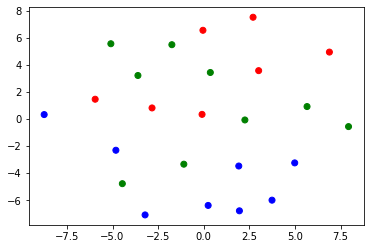

<Figure size 800x1600 with 0 Axes>

In [92]:
fig = plt.figure()
plt.figure(figsize=(2,4), dpi=400)
ax = fig.add_subplot(1,1,1)
label_set = list(set(tars[0]))
ax.scatter(xs,ys,c=cs,label=ts)

#legend = ax.legend(loc='best')
fig.savefig('cluster')

## 3d

In [93]:
mds3 = MDS(n_components=3)
x = np.squeeze(cls_results[0])
x.shape
x_transformed = mds3.fit_transform(x)
x_transformed.shape

(24, 3)

In [94]:
labs = np.array(tars[0])
np.where(tars[0] == 1)

(array([], dtype=int64),)

In [95]:
colors = ['b','r','y']
colors = [rgb2hex(x) for x in colors]
print(colors)
dot_color = [colors[i] for i in tars[0]]
xs, ys, zs, cs, ts = x_transformed[:,0], x_transformed[:,1], x_transformed[:,2], dot_color, tars[0]
len(xs),len(ys),len(zs),len(cs),len(ts)

['#0000ff', '#ff0000', '#bfbf00']


(24, 24, 24, 24, 24)

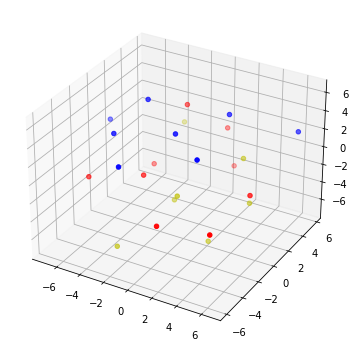

<Figure size 800x1600 with 0 Axes>

In [96]:
fig = plt.figure()
plt.figure(figsize=(2,4), dpi=400)
ax = fig.add_subplot(projection='3d')
fig.subplots_adjust(top=5, bottom=-5)


label_set = list(set(tars[0]))

ax.scatter(xs,ys,zs,c=cs,label=ts)

#legend = ax.legend(loc='best')
fig.savefig('cluster')

In [3]:
a = torch.Tensor([1])

In [6]:
if a in [1,2]:
    print(a)

tensor([1.])


In [ ]:
type(a.tolist()[0])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')


label_set = list(set(tars[0]))

ax.scatter(xs,ys,zs,c=cs,label=ts)

#legend = ax.legend(loc='best')
fig.savefig('cluster')